## Data 4380 Tabular Project with Harmful Brain Activity Dataset

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow, fastparquet

In [2]:
!jt -t oceans16

In [3]:
training = pd.read_csv('train.csv')

In [4]:
training

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


#### EEG Examples from Training Set

In [5]:
train_eeg1 = pd.read_parquet('train_eegs/1628180742.parquet', engine = 'pyarrow')

In [6]:
train_eeg2 = pd.read_parquet('train_eegs/351917269.parquet', engine = 'pyarrow')

In [7]:
train_eeg1

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


In [8]:
train_eeg2

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-38.000000,-8.800000,24.100000,11.690000,17.990000,-2.390000,17.200001,17.219999,-3.46,-25.950001,9.580000,31.17,-11.100000,-14.020000,-3.050000,15.62,21.629999,4.660000,36.209999,-29.480000
1,-51.529999,-11.350000,16.920000,3.610000,4.730000,-13.800000,8.150000,10.820000,-12.95,-34.349998,1.710000,24.07,-20.809999,-27.340000,-9.220000,11.79,20.219999,0.900000,28.660000,-15.290000
2,-32.509998,-5.500000,26.129999,11.380000,17.299999,-4.270000,16.370001,20.950001,-3.77,-26.650000,9.560000,31.00,-12.590000,-13.730000,1.550000,16.93,31.530001,14.190000,38.570000,-6.360000
3,-33.270000,-1.550000,29.180000,12.330000,18.080000,-5.700000,15.220000,16.760000,0.23,-24.469999,9.370000,29.66,-14.300000,-13.040000,-1.440000,18.75,28.129999,9.370000,38.840000,-26.020000
4,-47.459999,-14.740000,15.630000,-1.720000,2.270000,-19.090000,-2.430000,-0.940000,-10.85,-35.840000,-6.060000,18.01,-26.959999,-31.260000,-19.129999,-2.99,9.560000,-9.150000,17.070000,-24.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-80.480003,-32.880001,1.500000,-20.059999,-31.540001,-37.029999,-25.830000,-39.220001,3.95,-31.219999,-29.379999,6.05,-14.700000,-38.049999,-47.720001,-5.20,-9.880000,-53.930000,-35.430000,-10.770000
13996,-87.220001,-44.430000,-10.560000,-32.639999,-36.230000,-47.389999,-39.779999,-51.470001,-0.52,-38.410000,-39.230000,-1.53,-21.820000,-44.450001,-55.279999,-9.50,-16.420000,-60.730000,-43.169998,-24.580000
13997,-96.750000,-54.709999,-21.059999,-42.419998,-46.310001,-58.959999,-49.599998,-60.509998,-7.53,-44.459999,-47.759998,-4.17,-26.530001,-48.189999,-60.580002,-16.32,-23.240000,-65.160004,-52.930000,-7.390000
13998,-83.529999,-40.419998,-7.320000,-30.000000,-34.970001,-45.669998,-36.279999,-47.360001,4.54,-35.889999,-36.770000,9.74,-15.960000,-43.250000,-49.930000,-3.53,-5.770000,-52.869999,-40.290001,-2.190000


In [9]:
np.unique(training.patient_id).shape

(1950,)

In [10]:
np.unique(training.eeg_id).shape

(17089,)

In [11]:
np.unique(training.spectrogram_id).shape

(11138,)

There isn't a single EEG for each individual patient. There are multiple. 17k EEGs and just under 2k individual patients. The same is true for Spectrograms. There are 11k of those.

In [12]:
np.unique(training.expert_consensus)

array(['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'], dtype=object)

Expert consensus identifies the possible levels of the target variable.

In [13]:
training.lpd_vote.value_counts()

lpd_vote
0     77675
1      9680
2      4618
3      4011
4      2290
5      1323
6      1065
7       863
13      769
14      739
10      629
8       616
12      589
9       574
15      557
11      545
17      120
16       92
18       45
Name: count, dtype: int64

In [14]:
test_eeg_parquet = '3911565283.parquet'

In [15]:
test_eeg = pd.read_parquet('test_eegs/3911565283.parquet', engine = 'pyarrow')

In [16]:
test_eeg

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,9.210000,-47.459999,15.100000,8.220000,-16.900000,-22.99,-25.820000,-10.090000,28.370001,-3.010000,-27.299999,101.040001,35.110001,14.540000,18.330000,28.540001,44.090000,69.650002,30.74,171.679993
1,-3.590000,-30.290001,32.380001,10.800000,-68.980003,-21.60,-15.080000,-9.210000,26.360001,-8.980000,-32.279999,95.800003,26.389999,4.820000,10.540000,20.559999,32.060001,59.439999,23.32,178.279999
2,-26.040001,-60.070000,2.370000,-10.150000,-34.689999,-31.40,-31.920000,-26.980000,-1.940000,-28.770000,-49.770000,73.449997,-3.680000,-17.320000,-16.150000,-8.270000,5.330000,45.180000,9.49,306.739990
3,-3.040000,-36.250000,29.559999,14.530000,-14.010000,-11.90,-14.230000,-6.310000,26.040001,-2.770000,-25.030001,91.010002,22.610001,6.900000,9.930000,15.480000,33.580002,69.620003,31.01,223.259995
4,-4.630000,-20.160000,25.190001,1.190000,-44.580002,-23.51,-30.709999,-17.600000,25.420000,-8.860000,-33.959999,89.449997,19.440001,-2.080000,6.110000,8.380000,24.180000,55.869999,19.91,170.759995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-26.889999,-45.480000,-17.250000,-23.570000,19.059999,-9.40,-27.120001,-21.580000,-75.760002,-65.800003,-88.790001,-30.090000,-49.830002,-75.339996,-61.139999,-71.889999,-53.299999,-8.130000,-12.38,-34.799999
9996,-24.049999,-41.689999,-13.450000,-26.219999,14.210000,0.02,-30.030001,-22.219999,-75.440002,-68.639999,-91.099998,-33.180000,-45.610001,-78.809998,-61.259998,-71.889999,-55.009998,-12.320000,-15.15,-27.799999
9997,-34.500000,-55.340000,-25.959999,-30.670000,8.890000,-9.74,-38.520000,-30.330000,-87.080002,-70.690002,-92.320000,-37.349998,-57.290001,-80.209999,-67.320000,-72.919998,-57.110001,-12.330000,-15.20,21.980000
9998,-16.110001,-35.980000,-8.570000,-12.020000,28.580000,5.45,-20.510000,-10.300000,-65.459999,-50.730000,-71.650002,-15.970000,-36.380001,-59.660000,-46.310001,-51.520000,-39.740002,6.770000,3.74,-5.800000


The test EEG is a 50 second recording which matches the sub EEGs identified in the training csv. The overall training EEGs are larger than the testing EEG. Each of them contains multiple sub EEGs which match the size of the testing EEG.

There are 10000 rows in the testing EEG which means for every second of EEG recording, 200 rows of data are collected.

In [17]:
test_spectrogram = pd.read_parquet('test_spectrograms/853520.parquet', engine = 'pyarrow')

In [18]:
test_spectrogram

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,14.910000,17.110001,11.660000,11.73,6.08,4.54,4.31,3.38,2.05,...,0.07,0.06,0.05,0.06,0.05,0.05,0.06,0.05,0.04,0.05
1,3,11.130000,10.950000,10.770000,5.07,4.03,3.24,3.61,2.98,1.54,...,0.05,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.02
2,5,10.880000,10.570000,8.790000,5.33,2.44,1.48,1.83,0.99,0.89,...,0.04,0.04,0.04,0.03,0.03,0.04,0.04,0.05,0.06,0.06
3,7,19.450001,18.200001,17.719999,13.38,4.17,1.88,1.84,1.22,1.27,...,0.03,0.03,0.05,0.08,0.07,0.07,0.08,0.03,0.03,0.03
4,9,21.650000,22.530001,23.160000,17.00,7.19,3.89,3.65,2.72,2.35,...,0.04,0.04,0.05,0.05,0.06,0.05,0.05,0.05,0.04,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,591,15.580000,18.209999,14.020000,15.96,4.36,4.98,2.68,2.22,2.03,...,0.48,0.59,0.59,0.73,0.44,0.41,0.56,0.60,0.61,0.60
296,593,17.209999,20.219999,20.889999,17.16,9.15,4.14,2.49,2.71,1.60,...,0.26,0.37,0.41,0.36,0.48,0.36,0.39,0.46,0.34,0.32
297,595,9.610000,13.320000,9.190000,11.50,8.11,5.53,5.57,3.69,3.19,...,0.58,0.37,0.17,0.14,0.13,0.30,0.36,0.39,0.56,0.29
298,597,8.430000,11.840000,13.640000,10.56,8.63,5.80,2.98,1.48,0.96,...,0.54,0.22,0.17,0.16,0.11,0.38,0.45,0.45,0.45,0.34


There are a few things I don't yet understand about the spectrogram data. The test spectrogram is 300x401 and the number of training spectrograms don't match the number of training EEGs. I would think there would be a spectrogram for every EEG. It's possible that this is a missing data issue. Or I just don't fully understand what a spectrogram is.

My understanding is that these are ways of visualizing the EEG recordings. You get a portrayal of brain activity over time in color. This is why I would have expected a spectrogram for every EEG.

In [19]:
training.spectrogram_id.isnull().sum()

0

It doesn't appear to be missing data that is the issue. There just aren't the same number of individual spectrograms as there are EEGs which is confusing to me.

#### Creating Column for Total Number of Votes

In [20]:
training['total_votes'] = (training.seizure_vote + training.lpd_vote + training.gpd_vote 
                           + training.lrda_vote + training.grda_vote + training.other_vote)

In [21]:
training

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,3
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,3
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,3
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,3
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0,3
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0,3
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0,3
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0,3


In [22]:
np.unique(training.total_votes)

array([ 1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28])

In [23]:
training.total_votes.value_counts()

total_votes
3     51867
15    10665
13     7525
16     5191
1      4360
12     4356
5      3974
14     3887
4      3451
11     2602
2      2316
18     1934
17     1445
10     1146
6       883
20      634
19      250
21      179
22       54
23       24
25       20
24       17
28        6
26        6
27        5
7         3
Name: count, dtype: int64

Rows with 3 total expert votes make up nearly half of my data, so splitting based on total votes may not be the best thing to do. At the very least, splitting to include rows where at least 3 experts voted would prevent losing that much of the data.

#### Creating Column for Variability in Voting

The category of activity associated with each row is determined by the votes. Not only is it important to emphasize rows where more experts voted so that the consensus is more meaningful, it's also important to emphasize rows where there was full agreement because that suggests less ambiguity about the nature of the activity shown in the EEG and Spectrogram. It's clearly more meaningful when 20 experts agree than when 3 do, and it's also probably more meaningful when 10 agree and 0 disagree than when 11 agree and 9 disagree.

These columns will allow me to select parquets of EEG and Spectrogram to do exploratory data analysis with in order to get a better understanding of the data.

In [24]:
vote_df = training[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].copy()

In [25]:
vote_df

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3,0,0,0,0,0
1,3,0,0,0,0,0
2,3,0,0,0,0,0
3,3,0,0,0,0,0
4,3,0,0,0,0,0
...,...,...,...,...,...,...
106795,0,0,0,3,0,0
106796,0,0,0,3,0,0
106797,0,0,0,3,0,0
106798,0,0,0,3,0,0


In [26]:
vote_df_rows = [[vote_df.seizure_vote[i], vote_df.lpd_vote[i], vote_df.gpd_vote[i], vote_df.lrda_vote[i], 
                vote_df.grda_vote[i], vote_df.other_vote[i]] for i in range(vote_df.shape[0])]

In [27]:
training

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,3
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,3
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,3
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,3
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0,3
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0,3
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0,3
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0,3


In [28]:
unique_votes = np.zeros(len(vote_df_rows))

In [29]:
len(unique_votes)

106800

In [30]:
for i in range(len(vote_df_rows)):
    unique_count = 0
    for j in range(len(vote_df_rows[0])):
        if vote_df_rows[i][j] > 0:
            unique_votes[i] += 1

Checking the range of unique votes to be sure it's 1 to 6 as intended.

In [31]:
len(unique_votes), max(unique_votes), min(unique_votes)

(106800, 6.0, 1.0)

Creating new column for number of unique votes.

In [32]:
training['unique_votes'] = unique_votes

In [33]:
training.unique_votes.value_counts()

unique_votes
1.0    51037
2.0    30288
3.0    17268
4.0     5938
5.0     2153
6.0      116
Name: count, dtype: int64

This is what I'm going with for now. It at least tells me that by far most rows in the data had absolute consensus or close to it. With the column for number of total votes I can narrow down this data further and select at random from that subset.

#### Exploratory Data Analysis

For the purpose of better understanding my features (the EEG features specifically for now), I'll choose 5 parquets for each brain activity. To narrow down the set of data being pulled from in order to better ensure that I'm doing exploratory data analysis with meaningful data (rows which are strongly associated with their assigned activity type so that there's less ambiguity about which category the row falls in), I'll pull only from rows with an absolute consensus (number of unique votes = 1) and at least 3 votes (number of total votes >= 3). I was going to make it at least 8 total votes, but that cut far too much of the data out.

After that, I'll split that subset by category of brain activity. From those 6 remaining subsets, I'll pull 5 rows at random and use the EEG sub IDs to get the data for the corresponding 50 seconds of EEG recording.

The goal for EDA is to plot the time series data for each column and compare across classes. I also want to look at summary statistics, and then consider cosine similarity.

### Splitting Data

In [34]:
initial_split = training[training['unique_votes'] == 1] # split by unique votes

In [35]:
initial_split.unique_votes.value_counts()

unique_votes
1.0    51037
Name: count, dtype: int64

##### Making Sure Each Target Class Has Enough To Pull From

In [36]:
initial_split.expert_consensus.value_counts()

expert_consensus
Seizure    18245
GRDA       11673
Other       7486
LRDA        5551
LPD         5062
GPD         3020
Name: count, dtype: int64

In [37]:
second_split = initial_split[initial_split['total_votes'] > 2] # split by total votes

In [38]:
second_split

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes,unique_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,3,1.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,3,1.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,3,1.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,3,1.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0,3,1.0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0,3,1.0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0,3,1.0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0,3,1.0


##### Checking Target Class Value Counts

In [39]:
second_split.expert_consensus.value_counts()

expert_consensus
Seizure    17993
GRDA       11276
LRDA        5343
Other       4556
LPD         3794
GPD         2015
Name: count, dtype: int64

### Getting Target Class Splits of Data

In [40]:
other_split = second_split[second_split['expert_consensus'] == 'Other']
lpd_split = second_split[second_split['expert_consensus'] == 'LPD']
gpd_split = second_split[second_split['expert_consensus'] == 'GPD']
lrda_split = second_split[second_split['expert_consensus'] == 'LRDA']
seizure_split = second_split[second_split['expert_consensus'] == 'Seizure']
grda_split = second_split[second_split['expert_consensus'] == 'GRDA']

#### Selecting Rows from Target Splits

In [41]:
target_splits = [other_split, lpd_split, gpd_split, lrda_split, grda_split, seizure_split]

In [42]:
for s in target_splits:
    print(np.unique(s.eeg_id).shape)

(1530,)
(584,)
(194,)
(249,)
(861,)
(2286,)


In [43]:
other_eegs = np.unique(other_split.eeg_id)
lpd_eegs = np.unique(lpd_split.eeg_id)
gpd_eegs = np.unique(gpd_split.eeg_id)
lrda_eegs = np.unique(lrda_split.eeg_id)
grda_eegs = np.unique(grda_split.eeg_id)
seizure_eegs = np.unique(seizure_split.eeg_id)

In [44]:
eeg_lists = [other_eegs, lpd_eegs, gpd_eegs, lrda_eegs, grda_eegs, seizure_eegs]

In [45]:
import random
random_ids = []
for e in eeg_lists:
    for i in range(5):
        random_ids.append(random.choice(e))

In [46]:
other_eeg_ids = [random_ids[i] for i in range(5)]
lpd_eeg_ids = [random_ids[i] for i in range(5, 10)]
gpd_eeg_ids = [random_ids[i] for i in range(10, 15)]
lrda_eeg_ids = [random_ids[i] for i in range(15, 20)]
grda_eeg_ids = [random_ids[i] for i in range(20, 25)]
seizure_eeg_ids = [random_ids[i] for i in range(25, 30)]

The above lists give me 5 unique EEG ids for each type of brain activity so that I can plot these EEGs and compare across classes of the target variable.

#### Getting an EEG sub ID for each unique EEG

This is important to do because it ensures that the dimensions of each EEG recording being compared match one another and also match the dimensions of the testing EEG shown above.

#### Other

In [47]:
other_eeg_ids

[4201495772, 3768793174, 3188191469, 2149850788, 2469408774]

In [48]:
other_eeg1 = pd.read_parquet('train_eegs/4102477680.parquet', engine = 'pyarrow')
other_eeg2 = pd.read_parquet('train_eegs/3198721054.parquet', engine = 'pyarrow')
other_eeg3 = pd.read_parquet('train_eegs/3186975354.parquet', engine = 'pyarrow')
other_eeg4 = pd.read_parquet('train_eegs/3383182892.parquet', engine = 'pyarrow')
other_eeg5 = pd.read_parquet('train_eegs/1667193431.parquet', engine = 'pyarrow')

#### Confirmation Note

200 rows of EEG data per second. The above EEG has one 50 second recording start at 0 seconds and one at 2 seconds, so it contains 52 seconds of EEG data which results in 10400 rows of EEG data. So, when pulling a sub EEG I can just pull the 10000 rows covered by that recording.

In [49]:
other_sub1 = other_eeg1.iloc[400:10400].reset_index()
other_sub2 = other_eeg2.iloc[3600:13600].reset_index()
other_sub3 = other_eeg3.reset_index()
other_sub4 = other_eeg4.iloc[8800:18800].reset_index()
other_sub5 = other_eeg5.iloc[1200:11200].reset_index()

In [50]:
other_sub1 = other_sub1.drop(columns = 'index')
other_sub2 = other_sub2.drop(columns = 'index')
other_sub3 = other_sub3.drop(columns = 'index')
other_sub4 = other_sub4.drop(columns = 'index')
other_sub5 = other_sub5.drop(columns = 'index')

#### LPD

In [51]:
lpd_eeg_ids

[2933067689, 3496315311, 3160190371, 1351916101, 1268612404]

In [52]:
lpd_eeg1 = pd.read_parquet('train_eegs/3289898692.parquet', engine = 'pyarrow')
lpd_eeg2 = pd.read_parquet('train_eegs/2066783405.parquet', engine = 'pyarrow')
lpd_eeg3 = pd.read_parquet('train_eegs/625759288.parquet', engine = 'pyarrow')
lpd_eeg4 = pd.read_parquet('train_eegs/970022590.parquet', engine = 'pyarrow')
lpd_eeg5 = pd.read_parquet('train_eegs/50263119.parquet', engine = 'pyarrow')

In [53]:
lpd_sub1 = lpd_eeg1.iloc[8400:18400].reset_index()
lpd_sub2 = lpd_eeg2.iloc[1200:11200].reset_index()
lpd_sub3 = lpd_eeg3.iloc[1600:11600].reset_index()
lpd_sub4 = lpd_eeg4.iloc[12400:22400].reset_index()
lpd_sub5 = lpd_eeg5.iloc[6400:16400].reset_index()

In [54]:
lpd_sub1 = lpd_sub1.drop(columns = 'index')
lpd_sub2 = lpd_sub2.drop(columns = 'index')
lpd_sub3 = lpd_sub3.drop(columns = 'index')
lpd_sub4 = lpd_sub4.drop(columns = 'index')
lpd_sub5 = lpd_sub5.drop(columns = 'index')

#### GPD

In [55]:
gpd_eeg_ids

[3847510588, 1492067494, 4096771384, 2973890540, 4213030366]

In [56]:
gpd_eeg1 = pd.read_parquet('train_eegs/1994040752.parquet', engine = 'pyarrow')
gpd_eeg2 = pd.read_parquet('train_eegs/3803226344.parquet', engine = 'pyarrow')
gpd_eeg3 = pd.read_parquet('train_eegs/2288065876.parquet', engine = 'pyarrow')
gpd_eeg4 = pd.read_parquet('train_eegs/4059528628.parquet', engine = 'pyarrow')
gpd_eeg5 = pd.read_parquet('train_eegs/2172212126.parquet', engine = 'pyarrow')

In [57]:
gpd_sub1 = gpd_eeg1.iloc[1200:11200].reset_index()
gpd_sub2 = gpd_eeg2.iloc[4000:14000].reset_index()
gpd_sub3 = gpd_eeg3.iloc[8000:18000].reset_index()
gpd_sub4 = gpd_eeg4.iloc[1600:11600].reset_index()
gpd_sub5 = gpd_eeg5.reset_index()

In [58]:
gpd_sub1 = gpd_sub1.drop(columns = 'index')
gpd_sub2 = gpd_sub2.drop(columns = 'index')
gpd_sub3 = gpd_sub3.drop(columns = 'index')
gpd_sub4 = gpd_sub4.drop(columns = 'index')
gpd_sub5 = gpd_sub5.drop(columns = 'index')

#### LRDA

In [59]:
lrda_eeg_ids

[3441128830, 80291334, 3804370834, 2460541903, 2424550660]

In [60]:
lrda_eeg1 = pd.read_parquet('train_eegs/1516493459.parquet', engine = 'pyarrow')
lrda_eeg2 = pd.read_parquet('train_eegs/974837509.parquet', engine = 'pyarrow')
lrda_eeg3 = pd.read_parquet('train_eegs/4177763675.parquet', engine = 'pyarrow')
lrda_eeg4 = pd.read_parquet('train_eegs/3619881940.parquet', engine = 'pyarrow')
lrda_eeg5 = pd.read_parquet('train_eegs/3926584976.parquet', engine = 'pyarrow')

In [61]:
lrda_sub1 = lrda_eeg1.iloc[1200:11200].reset_index()
lrda_sub2 = lrda_eeg2.iloc[5600:15600].reset_index()
lrda_sub3 = lrda_eeg3.iloc[4400:14400].reset_index()
lrda_sub4 = lrda_eeg4.iloc[400:10400].reset_index()
lrda_sub5 = lrda_eeg5.iloc[2800:12800].reset_index()

In [62]:
lrda_sub1 = lrda_sub1.drop(columns = 'index')
lrda_sub2 = lrda_sub2.drop(columns = 'index')
lrda_sub3 = lrda_sub3.drop(columns = 'index')
lrda_sub4 = lrda_sub4.drop(columns = 'index')
lrda_sub5 = lrda_sub5.drop(columns = 'index')

#### GRDA

In [63]:
grda_eeg_ids

[2202013989, 1473684439, 4053555243, 3322688508, 1936347328]

In [64]:
grda_eeg1 = pd.read_parquet('train_eegs/1378307572.parquet', engine = 'pyarrow')
grda_eeg2 = pd.read_parquet('train_eegs/1382307363.parquet', engine = 'pyarrow')
grda_eeg3 = pd.read_parquet('train_eegs/135276897.parquet', engine = 'pyarrow')
grda_eeg4 = pd.read_parquet('train_eegs/2019584976.parquet', engine = 'pyarrow')
grda_eeg5 = pd.read_parquet('train_eegs/1113313228.parquet', engine = 'pyarrow')

In [65]:
grda_sub1 = grda_eeg1.iloc[10400:20400].reset_index()
grda_sub2 = grda_eeg2.iloc[4800:14800].reset_index()
grda_sub3 = grda_eeg3.iloc[2400:12400].reset_index()
grda_sub4 = grda_eeg4.iloc[6400:16400].reset_index()
grda_sub5 = grda_eeg5.iloc[2400:12400].reset_index()

In [66]:
grda_sub1 = grda_sub1.drop(columns = 'index')
grda_sub2 = grda_sub2.drop(columns = 'index')
grda_sub3 = grda_sub3.drop(columns = 'index')
grda_sub4 = grda_sub4.drop(columns = 'index')
grda_sub5 = grda_sub5.drop(columns = 'index')

#### Seizure

In [67]:
seizure_eeg_ids

[1187564709, 3075244343, 3600356709, 2599722577, 2387319700]

In [68]:
seizure_eeg1 = pd.read_parquet('train_eegs/714742900.parquet', engine = 'pyarrow')
seizure_eeg2 = pd.read_parquet('train_eegs/2083690052.parquet', engine = 'pyarrow')
seizure_eeg3 = pd.read_parquet('train_eegs/2754369716.parquet', engine = 'pyarrow')
seizure_eeg4 = pd.read_parquet('train_eegs/319967765.parquet', engine = 'pyarrow')
seizure_eeg5 = pd.read_parquet('train_eegs/4133663113.parquet', engine = 'pyarrow')

In [69]:
seizure_sub1 = seizure_eeg1.iloc[4800:14800].reset_index()
seizure_sub2 = seizure_eeg2.iloc[18000:28000].reset_index()
seizure_sub3 = seizure_eeg3.iloc[22000:32000].reset_index()
seizure_sub4 = seizure_eeg4.iloc[14400:24400].reset_index()
seizure_sub5 = seizure_eeg5.iloc[5200:15200].reset_index()

In [70]:
seizure_sub1 = seizure_sub1.drop(columns = 'index')
seizure_sub2 = seizure_sub2.drop(columns = 'index')
seizure_sub3 = seizure_sub3.drop(columns = 'index')
seizure_sub4 = seizure_sub4.drop(columns = 'index')
seizure_sub5 = seizure_sub5.drop(columns = 'index')

### Initial Visualization of EEG Data

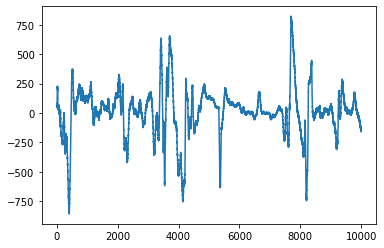

In [71]:
plt.plot(other_sub1['Fp1'])

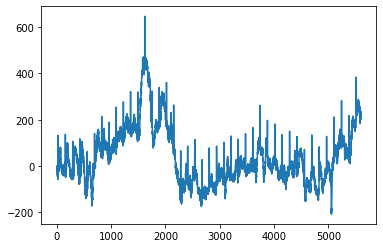

In [72]:
plt.plot(lpd_sub1['Fp1'])

In [73]:
lpd_sub1

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,0.31,-56.470001,-24.900000,-33.779999,-46.830002,-46.380001,-30.000000,-31.200001,-25.219999,-8.71,-33.720001,-53.450001,-36.570000,-8.52,-50.430000,-45.590000,-14.74,-37.500000,-0.70,-21.420000
1,-9.00,-60.540001,-27.750000,-35.930000,-48.840000,-50.689999,-33.240002,-31.110001,-22.520000,-7.82,-33.450001,-51.250000,-33.139999,-3.90,-47.009998,-37.430000,-11.16,-33.990002,1.41,86.099998
2,-20.73,-64.690002,-28.959999,-36.090000,-52.689999,-52.340000,-31.969999,-31.170000,-23.010000,-7.01,-32.650002,-66.839996,-39.930000,-4.33,-45.470001,-40.410000,-10.81,-31.580000,3.17,154.919998
3,-7.83,-55.450001,-22.889999,-31.240000,-46.410000,-49.580002,-31.370001,-28.680000,-10.080000,0.11,-27.490000,-49.599998,-32.840000,-2.11,-42.330002,-38.139999,-8.82,-30.730000,6.00,55.009998
4,-3.75,-52.110001,-21.670000,-30.200001,-46.299999,-51.610001,-32.049999,-27.459999,-4.350000,0.81,-27.820000,-13.330000,-28.070000,-5.34,-44.520000,-37.570000,-11.49,-33.290001,5.06,65.760002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
def time_series_comparison(other, lpd, gpd, lrda, grda, seizure):
    plt.plot(other, color = 'b')
    plt.plot(lpd, color = 'g')
    plt.plot(gpd, color = 'r')
    plt.plot(lrda, color = 'b')
    plt.plot(seizure, color = 'm')
    plt.title('Comparison of {} Readings Across Types of Brain Activity'.format(col))
    plt.show()

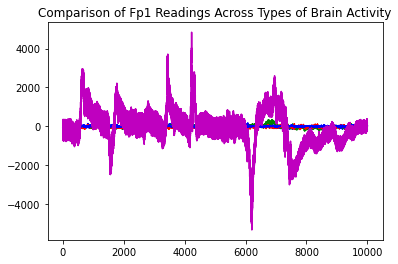

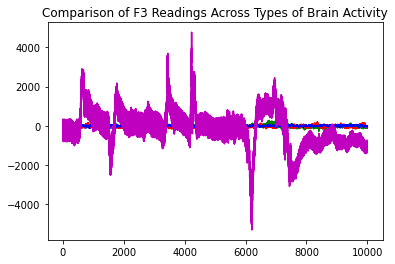

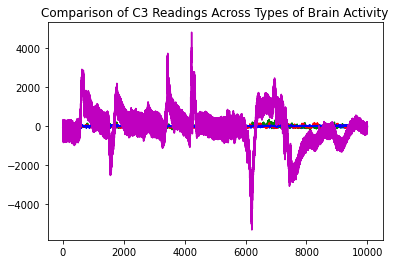

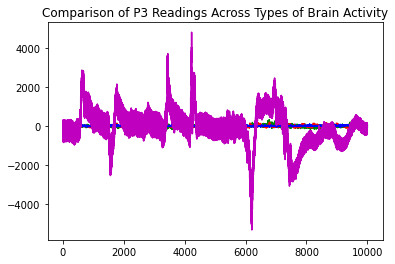

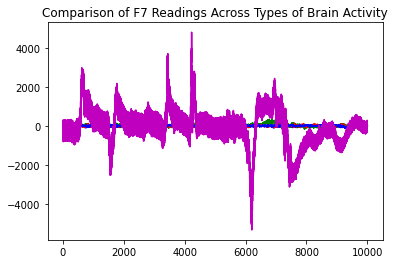

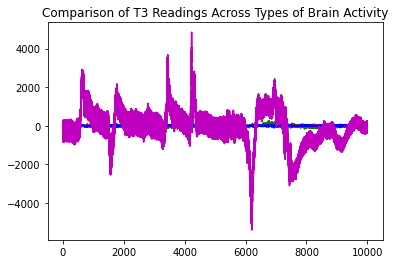

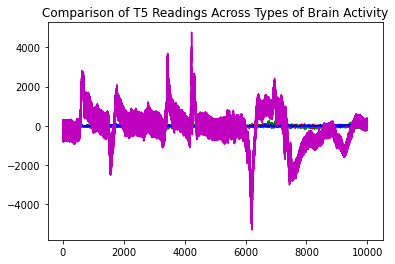

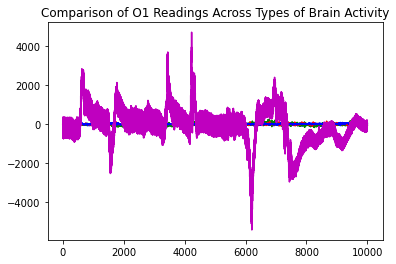

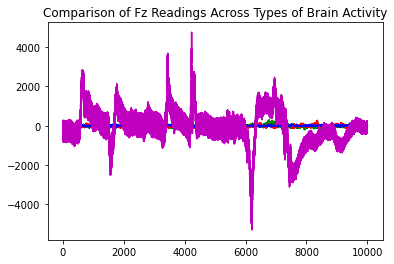

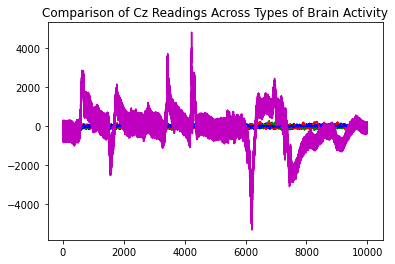

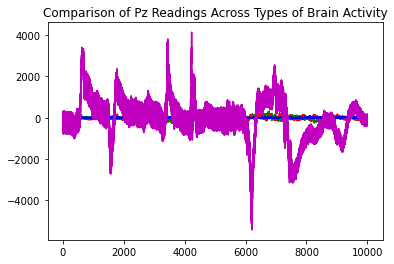

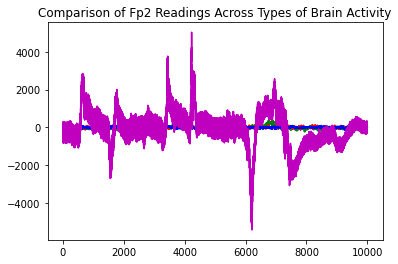

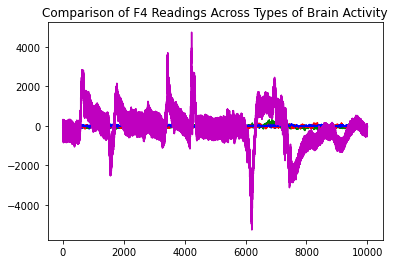

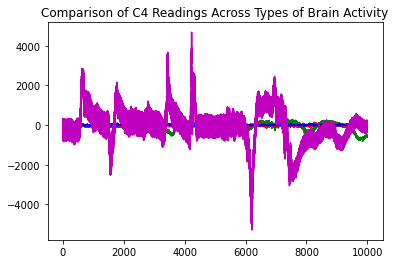

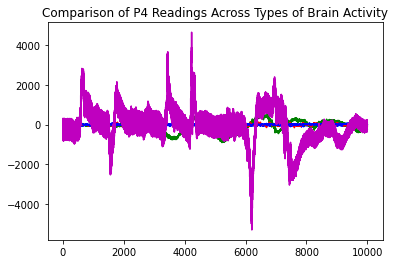

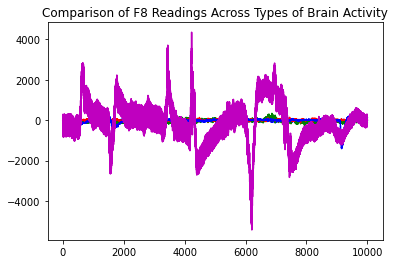

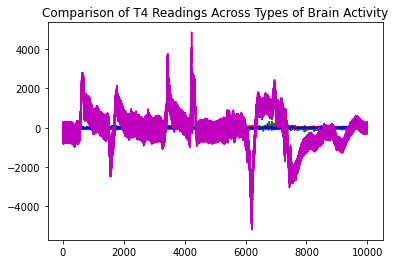

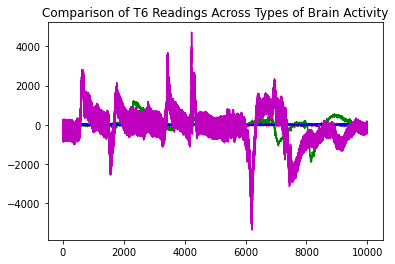

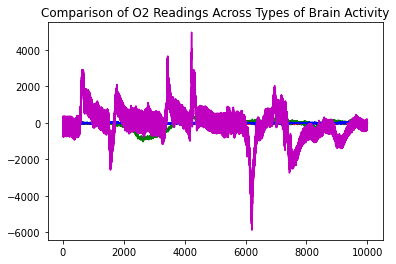

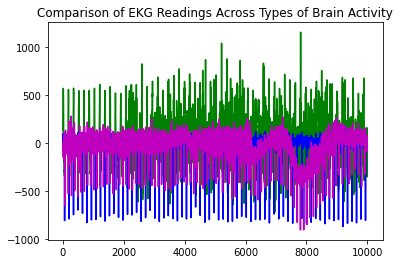

In [123]:
for col in test_eeg.columns:
    time_series_comparison(other_sub2[col], lpd_sub2[col], gpd_sub2[col], lrda_sub2[col], grda_sub2[col], seizure_sub2[col])

#### Checking for Null Values in Sub EEGs

List of sub EEGs and columns with null values:

lpd_sub1 has 4397 missing values in each column

This was the only sub EEG with any missing values. I found this by looping over the columns for each sub EEG and taking the sum of pandas' isnull() function. Because this is the only sub EEG with missing values, that likely isn't the issue with my plot's line visibility. I need to find a way to make the lines more visible or maybe plot them on separate plots and compare the data that way.

I tested the above function on the sub2 EEGs for each type of brain activity and it is more visible, but not by very much. The local maxima and minima of the magenta line (the seizure data) stand out from the other types of brain activity in this plot, but it isn't easy to tell much beyond that.

I looped over each column for the sub2 EEGs to get comparisons for each column. The trend there is the same as before for each column. The magenta line which is the line for the seizure data stands out with very high local maxima and very low local minima. The only column this isn't true for is the EKG column. These aren't readings from the brain, however. EKG's are electrocardiograms. They're electrical readings from the heart.

In [78]:
other_sub1.columns

Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'],
      dtype='object')

In [117]:
for col in seizure_sub5.columns:
    print(pd.isnull(seizure_sub5[col]).sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
